In [ ]:
%matplotlib inline

In [8]:
from pathlib import Path
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import math
import cv2

from aptos.data_loader import ImgProcessor

In [ ]:
TRAIN_DIR = Path('../data/raw/train_images')

In [ ]:
train_imgs = list(TRAIN_DIR.glob('*.png'))
len(train_imgs)

In [ ]:
img = Image.open(train_imgs[10])
img

In [9]:
processor = ImgProcessor('.')

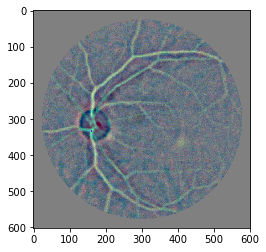

In [17]:
img = processor.process(str(train_imgs[6]))
plt.imshow(img)

In [ ]:
def scale_radius(img, scale):
    x = img[img.shape[0]//2, :, :].sum(1)
    r = (x > x.mean() / 10).sum() / 2
    s = scale * 1.0 / r
    return cv2.resize(img, None, fx=s, fy=s)

def crop_sq(im, tol=12):
    gb = cv2.GaussianBlur(im, (7, 7), 0)
    mask = (gb > tol).any(2)
    coords = np.argwhere(mask)
    y0, x0 = coords.min(axis=0)
    y1, x1 = coords.max(axis=0)
    cropped = im[y0:y1, x0:x1]
    return cropped

def process(f, debug=False):
    scale = 300
    try:
        print('Reading image')
        a = cv2.imread(str(f))[:, :, ::-1]  # bgr => rgb
        if debug:
            fig, axs = plt.subplots(5, figsize=(8, 40))
            axs[0].imshow(a)
            axs[0].set_title('original')
        print('Cropping')
        a = crop_sq(a)
        if debug:
            axs[1].imshow(a)
            axs[1].set_title('square cropped')
        print('Scaling')
        a = scale_radius(a, scale)
        if debug:
            axs[2].imshow(a)
            axs[2].set_title('scaled')
        print('Applying blur')
        gb = cv2.GaussianBlur(a, (0, 0), scale / 30)
        a = cv2.addWeighted(a, 4, gb, -4, 128)
        if debug:
            axs[3].imshow(a)
            axs[3].set_title('blurred')
        print('Applying circle')
        b = np.zeros(a.shape, dtype=np.uint8)
        cv2.circle(b, (a.shape[1]//2, a.shape[0]//2), int(scale * 0.92), (255, 255, 255), thickness=-1)
        a = a * b + 128 * (1 - b)
        if debug:
            axs[4].imshow(a)
            axs[4].set_title('circle cropped')
        return a
    except Exception as ex:
        print(f'Caught exception: {ex}')

In [7]:
%%timeit -n 100
img = process(train_imgs[10], debug=False)

Reading image
Cropping
Scaling
Applying blur
Applying circle
Reading image
Cropping
Scaling
Applying blur
Applying circle
Reading image
Cropping
Scaling
Applying blur
Applying circle
Reading image
Cropping
Scaling
Applying blur
Applying circle
Reading image
Cropping
Scaling
Applying blur
Applying circle
Reading image
Cropping
Scaling
Applying blur
Applying circle
Reading image
Cropping
Scaling
Applying blur
Applying circle
Reading image
Cropping
Scaling
Applying blur
Applying circle
Reading image
Cropping
Scaling
Applying blur
Applying circle
Reading image
Cropping
Scaling
Applying blur
Applying circle
Reading image
Cropping
Scaling
Applying blur
Applying circle
Reading image
Cropping
Scaling
Applying blur
Applying circle
Reading image
Cropping
Scaling
Applying blur
Applying circle
Reading image
Cropping
Scaling
Applying blur
Applying circle
Reading image
Cropping
Scaling
Applying blur
Applying circle
Reading image
Cropping
Scaling
Applying blur
Applying circle
Reading image
Cropping
S

Scaling
Applying blur
Applying circle
Reading image
Cropping
Scaling
Applying blur
Applying circle
Reading image
Cropping
Scaling
Applying blur
Applying circle
Reading image
Cropping
Scaling
Applying blur
Applying circle
Reading image
Cropping
Scaling
Applying blur
Applying circle
Reading image
Cropping
Scaling
Applying blur
Applying circle
Reading image
Cropping
Scaling
Applying blur
Applying circle
Reading image
Cropping
Scaling
Applying blur
Applying circle
Reading image
Cropping
Scaling
Applying blur
Applying circle
Reading image
Cropping
Scaling
Applying blur
Applying circle
Reading image
Cropping
Scaling
Applying blur
Applying circle
Reading image
Cropping
Scaling
Applying blur
Applying circle
Reading image
Cropping
Scaling
Applying blur
Applying circle
Reading image
Cropping
Scaling
Applying blur
Applying circle
Reading image
Cropping
Scaling
Applying blur
Applying circle
Reading image
Cropping
Scaling
Applying blur
Applying circle
Reading image
Cropping
Scaling
Applying blur
Ap

Cropping
Scaling
Applying blur
Applying circle
Reading image
Cropping
Scaling
Applying blur
Applying circle
Reading image
Cropping
Scaling
Applying blur
Applying circle
Reading image
Cropping
Scaling
Applying blur
Applying circle
Reading image
Cropping
Scaling
Applying blur
Applying circle
Reading image
Cropping
Scaling
Applying blur
Applying circle
Reading image
Cropping
Scaling
Applying blur
Applying circle
Reading image
Cropping
Scaling
Applying blur
Applying circle
Reading image
Cropping
Scaling
Applying blur
Applying circle
Reading image
Cropping
Scaling
Applying blur
Applying circle
Reading image
Cropping
Scaling
Applying blur
Applying circle
Reading image
Cropping
Scaling
Applying blur
Applying circle
Reading image
Cropping
Scaling
Applying blur
Applying circle
Reading image
Cropping
Scaling
Applying blur
Applying circle
Reading image
Cropping
Scaling
Applying blur
Applying circle
Reading image
Cropping
Scaling
Applying blur
Applying circle
Reading image
Cropping
Scaling
Applyin

Applying circle
Reading image
Cropping
Scaling
Applying blur
Applying circle
Reading image
Cropping
Scaling
Applying blur
Applying circle
Reading image
Cropping
Scaling
Applying blur
Applying circle
Reading image
Cropping
Scaling
Applying blur
Applying circle
Reading image
Cropping
Scaling
Applying blur
Applying circle
Reading image
Cropping
Scaling
Applying blur
Applying circle
Reading image
Cropping
Scaling
Applying blur
Applying circle
Reading image
Cropping
Scaling
Applying blur
Applying circle
Reading image
Cropping
Scaling
Applying blur
Applying circle
Reading image
Cropping
Scaling
Applying blur
Applying circle
Reading image
Cropping
Scaling
Applying blur
Applying circle
Reading image
Cropping
Scaling
Applying blur
Applying circle
Reading image
Cropping
Scaling
Applying blur
Applying circle
Reading image
Cropping
Scaling
Applying blur
Applying circle
Reading image
Cropping
Scaling
Applying blur
Applying circle
Reading image
Cropping
Scaling
Applying blur
Applying circle
Reading 

Scaling
Applying blur
Applying circle
Reading image
Cropping
Scaling
Applying blur
Applying circle
Reading image
Cropping
Scaling
Applying blur
Applying circle
Reading image
Cropping
Scaling
Applying blur
Applying circle
Reading image
Cropping
Scaling
Applying blur
Applying circle
Reading image
Cropping
Scaling
Applying blur
Applying circle
Reading image
Cropping
Scaling
Applying blur
Applying circle
Reading image
Cropping
Scaling
Applying blur
Applying circle
Reading image
Cropping
Scaling
Applying blur
Applying circle
Reading image
Cropping
Scaling
Applying blur
Applying circle
Reading image
Cropping
Scaling
Applying blur
Applying circle
Reading image
Cropping
Scaling
Applying blur
Applying circle
Reading image
Cropping
Scaling
Applying blur
Applying circle
Reading image
Cropping
Scaling
Applying blur
Applying circle
Reading image
Cropping
Scaling
Applying blur
Applying circle
Reading image
Cropping
Scaling
Applying blur
Applying circle
Reading image
Cropping
Scaling
Applying blur
Ap

Cropping
Scaling
Applying blur
Applying circle
Reading image
Cropping
Scaling
Applying blur
Applying circle
Reading image
Cropping
Scaling
Applying blur
Applying circle
Reading image
Cropping
Scaling
Applying blur
Applying circle
Reading image
Cropping
Scaling
Applying blur
Applying circle
Reading image
Cropping
Scaling
Applying blur
Applying circle
Reading image
Cropping
Scaling
Applying blur
Applying circle
Reading image
Cropping
Scaling
Applying blur
Applying circle
Reading image
Cropping
Scaling
Applying blur
Applying circle
Reading image
Cropping
Scaling
Applying blur
Applying circle
Reading image
Cropping
Scaling
Applying blur
Applying circle
Reading image
Cropping
Scaling
Applying blur
Applying circle
Reading image
Cropping
Scaling
Applying blur
Applying circle
Reading image
Cropping
Scaling
Applying blur
Applying circle
Reading image
Cropping
Scaling
Applying blur
Applying circle
Reading image
Cropping
Scaling
Applying blur
Applying circle
Reading image
Cropping
Scaling
Applyin

In [ ]:
plt.imshow(cv2.imread(str(train_imgs[8]))[:, :, ::-1])

In [ ]:
plt.imshow(scale_radius(cv2.imread(str(train_imgs[8]))[:, :, ::-1], 300))

In [ ]:
scale = 300
a = process(train_imgs[8])
plt.imshow(a)

In [ ]:
b = np.zeros(a.shape)
b[:2, :, :]

In [ ]:
b = np.zeros(a.shape, dtype=np.uint8)
b[:2, :, :]

In [ ]:
cv2.circle(b, (a.shape[1]//2, a.shape[0]//2), int(scale * 0.9), (255, 255, 255), thickness=-1)
plt.imshow(b)

In [ ]:
a = a * b + 128 * (1 - b)
plt.imshow(a)

In [ ]:
im = scale_radius(cv2.imread(str(train_imgs[8]))[:, :, ::-1], 300)
plt.imshow(im)

In [ ]:
def crop_sq(im, tol=6):
    mask = (im > tol).any(2)
    coords = np.argwhere(mask)
    y0, x0 = coords.min(axis=0)
    y1, x1 = coords.max(axis=0)
    cropped = im[y0:y1, x0:x1]
    return cropped

In [ ]:
tol = 6
mask = (im > tol).any(2)
mask.shape

In [ ]:
coords = np.argwhere(mask)
coords

In [ ]:
y0, x0 = coords.min(axis=0)
y1, x1 = coords.max(axis=0)
print(x0, y0, x1, y1)

In [ ]:
cropped = im[y0:y1, x0:x1, :]
plt.imshow(cropped)

In [ ]:
def crop_image(img,tol=0):
    # img is image data
    # tol  is tolerance
    mask = img>tol
    mesh = np.ix_(mask.any(1),mask.any(0))
    return img[mesh]

In [ ]:
plt.imshow(crop_image(a))

In [ ]:
labels_df.dtypes

In [ ]:
labels_df.iloc[[4, 5, 6]].loc[labels_df['diagnosis'] == 0, :].index.values

In [ ]:
grp_df = labels_df.groupby('diagnosis').count()
grp_df

In [ ]:
n = labels_df.shape[0]

In [ ]:
submission_df.groupby('avg').count()